<div style="text-align:center; font-family:'Times New Roman';">
    <div class="alert alert-block alert-info" style="padding: 10px;">
        <h1 style="font-size:25px;">EJ1 $\Rightarrow$ Reconocimiento y Detección de Objetos con DL</h1>
    </div>
</div>

Con la base de datos `animal_dataset_bbs`, cada grupo de prácticas deberá emplear una red neuronal convolucional capaz de reconocer y detectar, para un conjunto de imágenes nunca antes vistas por la red, qué animales contienen. La detección se llevará a cabo utilizando bounding boxes.

Además, se solicita realizar un análisis del error durante el entrenamiento y la validación para evaluar la predisposición al overfitting del modelo obtenido. También se espera la presentación de las curvas ROC y P-R. En este caso, se requiere mostrar la Intersection over Union (IoU) para determinar la precisión.


In [1]:
#!pip install bbox

import os
import shutil
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

#### Dataset

Les labels tenen la següent estructura: 

`Bear 192.799744 81.55219600000001 848.0 605.2449919999999`


In [2]:
def mv_label_to_folder(path_folder):
    # Listar todas las subcarpetas en la carpeta "train"
    class_folders = [f for f in os.listdir(path_folder) if os.path.isdir(os.path.join(path_folder, f))]

    # Para cada subcarpeta (clase) en "train"
    for class_folder in class_folders:
        # Crear la ruta completa de la carpeta "labels" y "train" para esta clase
        labels_path = os.path.join(path_folder, class_folder, "Label")
        train_path = os.path.join(path_folder, class_folder)

        # Mover los archivos desde "labels" a la carpeta actual en "train"
        for file in os.listdir(labels_path):
            file_path_labels = os.path.join(labels_path, file)
            file_path_train = os.path.join(train_path, file)

            # Mover el archivo
            shutil.move(file_path_labels, file_path_train)
            
        shutil.rmtree(labels_path)

def move_files(train_path):
    # Crear las carpetas "images" y "labels" si no existen
    images_path = os.path.join(train_path, "images")
    labels_path = os.path.join(train_path, "labels")
    
    os.makedirs(images_path, exist_ok=True)
    os.makedirs(labels_path, exist_ok=True)

    # Iterar sobre las carpetas en el directorio "train"
    for folder in os.listdir(train_path):
        folder_path = os.path.join(train_path, folder)
        
        if os.path.isdir(folder_path):
            # Mover archivos de imágenes a la carpeta "images"
            image_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]
            for image_file in image_files:
                src = os.path.join(folder_path, image_file)
                dst = os.path.join(images_path, image_file)
                shutil.move(src, dst)

            # Mover los archivos restantes a la carpeta "labels"
            other_files = [f for f in os.listdir(folder_path) if not f.endswith(".jpg")]
            for other_file in other_files:
                src = os.path.join(folder_path, other_file)
                dst = os.path.join(labels_path, other_file)
                shutil.move(src, dst)
            
            # Eliminar la carpeta original si está vacía
            if not os.listdir(folder_path):
                os.rmdir(folder_path)

In [3]:
mv_label_to_folder("/home/nct01/nct01317/VO/data/train")
mv_label_to_folder("/home/nct01/nct01317/VO/data/test")

move_files('/home/nct01/nct01317/VO/data/train')
move_files('/home/nct01/nct01317/VO/data/test')

#### Preprocessing

In [16]:
def adjust_labels(label_path, img_height, img_width, class_mapping):
    new_labels = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 5:
                class_name, xmin, ymin, xmax, ymax = parts

                # Convertir a float y normalizar
                xmin, ymin, xmax, ymax = map(float, [xmin, ymin, xmax, ymax])
                xmin /= img_width
                xmax /= img_width
                ymin /= img_height
                ymax /= img_height

                # Calcular centro, ancho y alto
                xcenter = (xmin + xmax) / 2
                ycenter = (ymin + ymax) / 2
                width = xmax - xmin
                height = ymax - ymin

                # Convertir a string
                class_num = class_mapping.get(class_name, -1)
                if class_num != -1:
                    new_label = f"{class_num} {xcenter} {ycenter} {width} {height}\n"
                    new_labels.append(new_label)

    return new_labels

def process_folder(train_folder, class_mapping):
    images_folder = os.path.join(train_folder, 'images')
    labels_folder = os.path.join(train_folder, 'labels')

    for file in os.listdir(images_folder):
        if file.endswith('.jpg'):
            image_path = os.path.join(images_folder, file)
            label_path = os.path.join(labels_folder, os.path.splitext(file)[0] + '.txt')

            if not os.path.exists(label_path):
                continue  # Skip if label file does not exist
         
            # Ajustar y guardar etiquetas
            new_h = new_w = 416
            new_labels = adjust_labels(label_path, new_h, new_w, class_mapping)
            with open(label_path, 'w') as file:
                file.writelines(new_labels)


# Ejemplo de uso
class_mapping = {'Bear': 0, 'Brown bear': 1, 'Bull': 2, 'Butterfly': 3, 'Camel': 4, 'Canary': 5, 'Caterpillar': 6, 'Cattle': 7, 'Centipede': 8, 'Cheetah': 9, 'Chicken': 10, 'Crab': 11, 'Crocodile': 12, 'Deer': 13, 'Duck': 14, 'Eagle': 15, 'Elephant': 16, 'Fish': 17, 'Fox': 18, 'Frog': 19, 'Giraffe': 20, 'Goat': 21, 'Goldfish': 22, 'Goose': 23, 'Hamster': 24, 'Harbor seal': 25, 'Hedgehog': 26, 'Hippopotamus': 27, 'Horse': 28, 'Jaguar': 29, 'Jellyfish': 30, 'Kangaroo': 31, 'Koala': 32, 'Ladybug': 33, 'Leopard': 34, 'Lion': 35, 'Lizard': 36, 'Lynx': 37, 'Magpie': 38, 'Monkey': 39, 'Moths and butterflies': 40, 'Mouse': 41, 'Mule': 42, 'Ostrich': 43, 'Otter': 44, 'Owl': 45, 'Panda': 46, 'Parrot': 47, 'Penguin': 48, 'Pig': 49, 'Polar bear': 50, 'Rabbit': 51, 'Raccoon': 52, 'Raven': 53, 'Red panda': 54, 'Rhinoceros': 55, 'Scorpion': 56, 'Sea lion': 57, 'Sea turtle': 58, 'Seahorse': 59, 'Shark': 60, 'Sheep': 61, 'Shrimp': 62, 'Snail': 63, 'Snake': 64, 'Sparrow': 65, 'Spider': 66, 'Squid': 67, 'Squirrel': 68, 'Starfish': 69, 'Swan': 70, 'Tick': 71, 'Tiger': 72, 'Tortoise': 73, 'Turkey': 74, 'Turtle': 75, 'Whale': 76, 'Woodpecker': 77, 'Worm': 78, 'Zebra': 79}
train_folder = '/home/nct01/nct01317/VO/data/train'
process_folder(train_folder, class_mapping)

test_folder = '/home/nct01/nct01317/VO/data/test'
process_folder(test_folder, class_mapping)

Tamaño de la imagen: 416 x 416


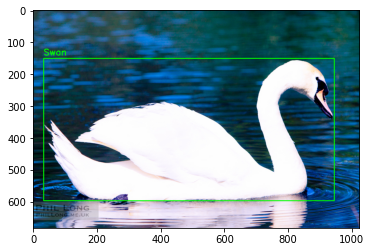

In [29]:
# Sanity Check

def visualize_random_image_and_bbox(folder_path, class_mapping):
    images_folder = os.path.join(folder_path, 'images')
    labels_folder = os.path.join(folder_path, 'labels')

    # Obtener una lista de archivos de imagen en la carpeta
    image_files = [file for file in os.listdir(images_folder) if file.endswith('.jpg')]

    # Seleccionar aleatoriamente una imagen
    random_image_file = random.choice(image_files)
    image_path = os.path.join(images_folder, random_image_file)
    label_file_name = os.path.splitext(random_image_file)[0] + '.txt'
    label_path = os.path.join(labels_folder, label_file_name)
    
    # Leer la imagen
    img = cv2.imread(image_path)

    # Obtener y mostrar el tamaño de la imagen
    h, w = 416, 416
    print(f'Tamaño de la imagen: {h} x {w}')

    # Leer las etiquetas
    with open(label_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            class_num, xcenter, ycenter, width, height = map(float, line.split())

            # Calcular las coordenadas de la bbox en píxeles
            xcenter *= w
            ycenter *= h
            width *= w
            height *= h
            x_min = int(xcenter - width / 2)
            y_min = int(ycenter - height / 2)
            x_max = int(xcenter + width / 2)
            y_max = int(ycenter + height / 2)

            # Dibujar la bbox en la imagen
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            class_name = [key for key, value in class_mapping.items() if value == int(class_num)]
            if class_name:
                cv2.putText(img, class_name[0], (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)

    # Crear una figura y ejes para la visualización
    fig, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB para matplotlib

    # Mostrar la imagen 
    plt.show()

# Ruta de ejemplo de la carpeta que contiene las imágenes y etiquetas
folder_path = '/gpfs/projects/nct01/nct01317/VO/data/train'

# Visualizar una imagen aleatoria, su tamaño y bbox
visualize_random_image_and_bbox(folder_path, class_mapping)

##### Model

In [ ]:
import torch

# Clonar el repositorio de YOLOv7 (solo necesitas hacer esto una vez)
#!git clone https://github.com/WongKinYiu/yolov7.git

# Importar el módulo del modelo YOLOv7 desde el repositorio clonado
#import sys
#sys.path.append('yolov7')

from models.yolo import Model

# Cargar la configuración del modelo desde el archivo .yaml
config_path = '/yolov7/cfg/training/yolov7.yaml'  # Asegúrate de que la ruta sea correcta
model = Model(config_path)

model.load_state_dict(torch.load('path_to_your_weights.pt')['model'])

model.eval()
